# Load data, separate into training, validation, and testing sets, and perform preprocessing

The goal is to predict California housing value given various property attributes.

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html

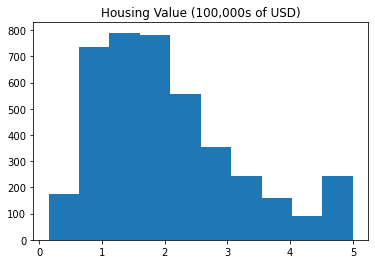

In [1]:
import tensorflow as tf
import numpy as np

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

data = fetch_california_housing()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2)

plt.title("Housing Value (100,000s of USD)")
plt.hist(y_test)
plt.show()

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

X_scale = StandardScaler().fit(X_train)
y_scale = StandardScaler().fit(y_train)

X_train = tf.convert_to_tensor(X_scale.transform(X_train), np.float32)
y_train = tf.convert_to_tensor(y_scale.transform(y_train), np.float32)
X_test = tf.convert_to_tensor(X_scale.transform(X_test), np.float32)
y_test = tf.convert_to_tensor(y_scale.transform(y_test), np.float32)

training = tf.data.Dataset.from_tensor_slices((X_train, y_train))
testing = tf.data.Dataset.from_tensor_slices((X_test, y_test))

validation_size = int(0.1 * len(training))

validation = training.take(validation_size)
training = training.skip(validation_size)

# Define main training and evaluation functions

Takes in a mini batch and layers and returns updated layers. The linear activation function is used since this is a regression task. Mean squared error is used as the loss function since it is well suited for regression. TensorFlow's GradientTape is used since it vastly reduces the time required for prototyping and development. Letting the computer handle derivatives makes it much easier to switch around functions.

https://www.tensorflow.org/api_docs/python/tf/GradientTape

In [2]:
def train(batch, w1, b1, out_w, out_b, eta):
    dw1 = tf.zeros(w1.shape)
    db1 = tf.zeros(b1.shape)

    out_dw = tf.zeros(out_w.shape)
    out_db = tf.zeros(out_b.shape)  

    for x, y_true in batch:
        with tf.GradientTape(persistent=True) as tape:
            # forward propagation
            tape.watch([w1, b1, out_w, out_b])
            y = evaluate(x, w1, b1, out_w, out_b)
            loss = mse(y, y_true)

        # back propagation
        out_dw += tape.gradient(loss, out_w)
        out_db += tape.gradient(loss, out_b)

        dw1 += tape.gradient(loss, w1)
        db1 += tape.gradient(loss, b1)

        del tape

    # adjust weights and bias with the mini batch results
    w1 = w1 - eta * dw1 / len(batch)
    b1 = b1 - eta * db1 / len(batch)
        
    out_w = out_w - eta * out_dw / len(batch)
    out_b = out_b - eta * out_db / len(batch)

    return w1, b1, out_w, out_b

def evaluate(x, w1, b1, out_w, out_b):
    x = tf.reshape(x, (1 ,x.shape[0]))
    z1 = tf.add(tf.matmul(x, w1), b1)
    y = tf.add(tf.matmul(z1, out_w), out_b)

    return y

def mse(y, y_true):
    return tf.square(y - y_true)

# Define hyperparameters and begin training

In [3]:
layer1_size = 100
epochs = 5
eta = 0.01
batch_size = 20

w1 = tf.random.uniform((X_train.shape[1], layer1_size), minval=0.0001, maxval=0.001)
b1 = tf.random.uniform((1, layer1_size), minval=0.0001, maxval=0.001)

out_w = tf.random.uniform((layer1_size, 1), minval=0.0001, maxval=0.001)
out_b = tf.random.uniform((1, 1), minval=0.0001, maxval=0.001)

for i in range(epochs):
    training = training.shuffle(len(training))
    batch_training = training.batch(batch_size)   

    for batch in batch_training:
        batch = tf.data.Dataset.from_tensor_slices(batch)
        w1, b1, out_w, out_b = train(batch, w1, b1, out_w, out_b, eta)

    error = 0
    for x, y in validation:
        error += mse(evaluate(x, w1, b1, out_w, out_b), y)

    print(f"Epoch {i + 1} - Validation Error: {float(error)}")

Epoch 1 - Validation Error: 795.8168334960938
Epoch 2 - Validation Error: 688.1010131835938
Epoch 3 - Validation Error: 683.2474975585938
Epoch 4 - Validation Error: 696.90234375
Epoch 5 - Validation Error: 683.432861328125


# Evaluate testing set

In [4]:
from sklearn.metrics import r2_score

y_pred = []
y_true = []
error = 0

for x, y in testing:
    prediction = float(y_scale.inverse_transform(np.array(evaluate(x, w1, b1, out_w, out_b)).reshape(-1, 1)))
    truth = float(y_scale.inverse_transform(np.array(y).reshape(-1, 1)))

    error += mse(prediction, truth)

    y_pred.append(prediction)
    y_true.append(truth)

print(f"Final error: {error}")
print(f"R^2 score: {r2_score(y_true, y_pred)}")


Final error: 2148.2373046875
R^2 score: 0.6043815098061165
